In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ========= ボックススコア =========
df = pd.read_csv("/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】ボックススコア.csv")

use = df[['試合ID','ピリオド区分','チームID','3P成功','3P試投','2P成功','2P試投']].copy()
use = use[use['ピリオド区分'].isin([1,2,3,4,5,6])].reset_index(drop=True)
use = use.sort_values(["試合ID","ピリオド区分","チームID"]).reset_index(drop=True)

agg = use.groupby(["試合ID",'ピリオド区分',"チームID"], as_index=False).agg(
    ThreeFGA_Sum=("3P試投","sum"),
    TwoFGA_Sum=("2P試投","sum"),
)

agg['is_OT']   = agg['ピリオド区分'].between(5, 6, inclusive='both')
agg["MINUTES"] = np.where(agg["is_OT"], 5, 10)

agg["ThreeFGA_per_min"] = agg["ThreeFGA_Sum"] / agg["MINUTES"]
agg["TwoFGA_per_min"]   = agg["TwoFGA_Sum"]   / agg["MINUTES"]

def corr_of(a, b, data):
    c = np.corrcoef(data[a], data[b])[0,1] if len(data) > 1 else np.nan
    return round(float(c), 3)

overall_raw   = corr_of("ThreeFGA_Sum","TwoFGA_Sum", agg)
overall_per_m = corr_of("ThreeFGA_per_min","TwoFGA_per_min", agg)

reg_raw   = corr_of("ThreeFGA_Sum","TwoFGA_Sum", agg[~agg["is_OT"]])
reg_per_m = corr_of("ThreeFGA_per_min","TwoFGA_per_min", agg[~agg["is_OT"]])

ot_raw    = corr_of("ThreeFGA_Sum","TwoFGA_Sum", agg[agg["is_OT"]])
ot_per_m  = corr_of("ThreeFGA_per_min","TwoFGA_per_min", agg[agg["is_OT"]])

print("\n=== Pearson r ===")
print(f"[ALL]   raw={overall_raw} / per_min={overall_per_m}")
print(f"[Q1-4]  raw={reg_raw}     / per_min={reg_per_m}")
print(f"[OT]    raw={ot_raw}      / per_min={ot_per_m}")
print(agg.head())

Matplotlib is building the font cache; this may take a moment.


FileNotFoundError: [Errno 2] No such file or directory: '/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】ボックススコア.csv'

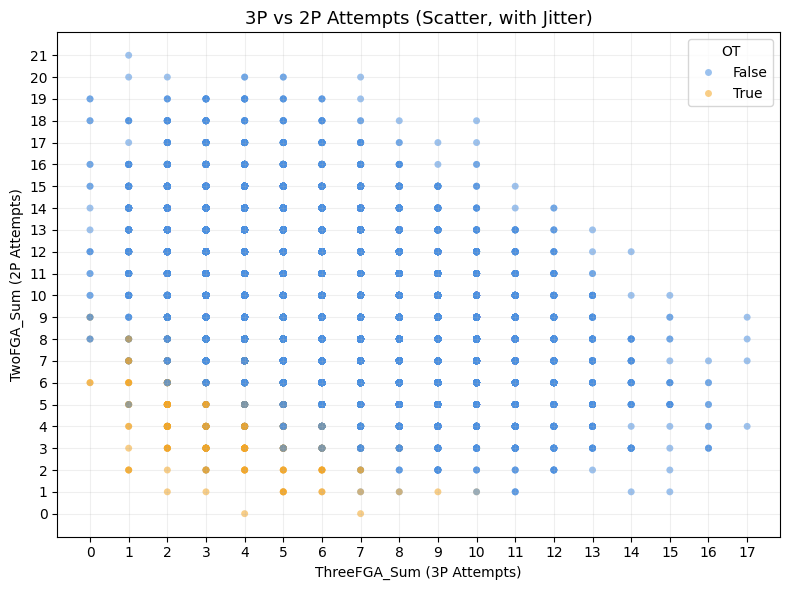

In [85]:
# ========== 可視化1：散布図（重なり軽減） ==========
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=agg,
    x="ThreeFGA_Sum",
    y="TwoFGA_Sum",
    hue="is_OT",
    palette={False: "#4A90E2", True: "#F5A623"},  # カラー固定で視認性UP
    s=25,         # 点をさらに小さく
    alpha=0.55,   # やや透過
    linewidth=0
)

plt.title("3P vs 2P Attempts (Scatter, with Jitter)", fontsize=13)
plt.xlabel("ThreeFGA_Sum (3P Attempts)")
plt.ylabel("TwoFGA_Sum (2P Attempts)")
plt.xticks(np.arange(0, 18, step=1))
plt.yticks(np.arange(0, 22, step=1))
plt.legend(title="OT")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [ ]:
# ========== 可視化2：Hexbin（密度ヒートマップ） ==========
plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    agg["ThreeFGA_Sum"],
    agg["TwoFGA_Sum"],
    gridsize=60,      # より細かい粒度（デフォルトは30）
    mincnt=1,
    cmap="viridis",   # 明暗コントラストが強く見やすい
    alpha=0.9
)
cb = plt.colorbar(hb)
cb.set_label("Number of periods")

plt.xlabel("ThreeFGA_Sum (3P Attempts)")
plt.ylabel("TwoFGA_Sum (2P Attempts)")
plt.title("3P vs 2P Attempts (Hexbin Density, gridsize=60)", fontsize=13)
plt.grid(alpha=0.2, linestyle="--")
plt.tight_layout()
plt.show()

In [ ]:
# プレイバイプレイ
df23_24 = pd.read_csv("/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】プレイバイプレイ_23-24シーズン.csv")
df24_25 = pd.read_csv("/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】プレイバイプレイ_24-25シーズン.csv")

use23_24 = df23_24[['試合ID','ピリオド','チームID','アクション1','エリア']].copy()
use24_25 = df24_25[['試合ID','ピリオド','チームID','アクション1','エリア']].copy()

use2 = pd.concat([use23_24, use24_25], ignore_index=True)

# 型を整える＆不要行除外
use2['ピリオド'] = pd.to_numeric(use2['ピリオド'], errors='coerce')
use2['チームID'] = pd.to_numeric(use2['チームID'], errors='coerce')
use2 = use2.dropna(subset=['試合ID','ピリオド','チームID','アクション1'])
use2 = use2[use2['チームID'] != 0]

# ===== エリアで2群に分割（先にフィルタしてから集計） =====
wing_labels = {"outsiderightwing", "outsideleftwing"}
twopoint_labels = {"underbasket","inthepaint","insiderightwing", "insideright", "insidecenter", "insideleft", "insideleftwing"}

use_twopoint = use2[use2['エリア'].isin(twopoint_labels)].copy()
use_outsidewing = use2[use2['エリア'].isin(wing_labels)].copy()
use_not_outside = use2[~use2['エリア'].isin(wing_labels)].copy()

def summarize(df):
    agg = df.groupby(['試合ID','ピリオド','チームID'])['アクション1'].agg(
        ThreeFGA_Sum=lambda s: s.isin([1, 2]).sum(),
        TwoFGA_Sum=lambda s: s.isin([3, 4, 5, 6]).sum()
    ).reset_index()

    # OTは5以上をOTとして包括
    agg['is_OT'] = agg['ピリオド'].isin([5, 6])
    agg['MINUTES'] = np.where(agg['is_OT'], 5, 10)

    agg['ThreeFGA_per_min'] = agg['ThreeFGA_Sum'] / agg['MINUTES']
    agg['TwoFGA_per_min']   = agg['TwoFGA_Sum']   / agg['MINUTES']
    return agg

action_counts                 = summarize(use2)

# チームID=745（越谷）抽出
action_counts_alphas = summarize(use2)[summarize(use2)['チームID'] == 745].copy()

# 安全な相関関数
def safe_corr(df, a, b):
    sub = df[[a,b]].dropna()
    if len(sub) < 2: return np.nan
    if sub[a].nunique() < 2 or sub[b].nunique() < 2: return np.nan
    return round(float(sub[a].corr(sub[b])), 3)

overall_raw_alphas   = safe_corr(action_counts_alphas, "ThreeFGA_Sum","TwoFGA_Sum")
overall_per_m_alphas = safe_corr(action_counts_alphas, "ThreeFGA_per_min","TwoFGA_per_min")
reg_raw_alphas       = safe_corr(action_counts_alphas[~action_counts_alphas["is_OT"]], "ThreeFGA_Sum","TwoFGA_Sum")
reg_per_m_alphas     = safe_corr(action_counts_alphas[~action_counts_alphas["is_OT"]], "ThreeFGA_per_min","TwoFGA_per_min")
ot_raw_alphas        = safe_corr(action_counts_alphas[action_counts_alphas["is_OT"]], "ThreeFGA_Sum","TwoFGA_Sum")
ot_per_m_alphas      = safe_corr(action_counts_alphas[action_counts_alphas["is_OT"]], "ThreeFGA_per_min","TwoFGA_per_min")

print("\n=== Pearson r (Koshigaya #745) ===")
print(f"[ALL]   raw={overall_raw_alphas} / per_min={overall_per_m_alphas}")
print(f"[Q1-4]  raw={reg_raw_alphas}     / per_min={reg_per_m_alphas}")
print(f"[OT]    raw={ot_raw_alphas}      / per_min={ot_per_m_alphas}")


=== Pearson r (Koshigaya #745) ===
[ALL]   raw=-0.383 / per_min=-0.441
[Q1-4]  raw=-0.437     / per_min=-0.437
[OT]    raw=-0.374      / per_min=-0.374


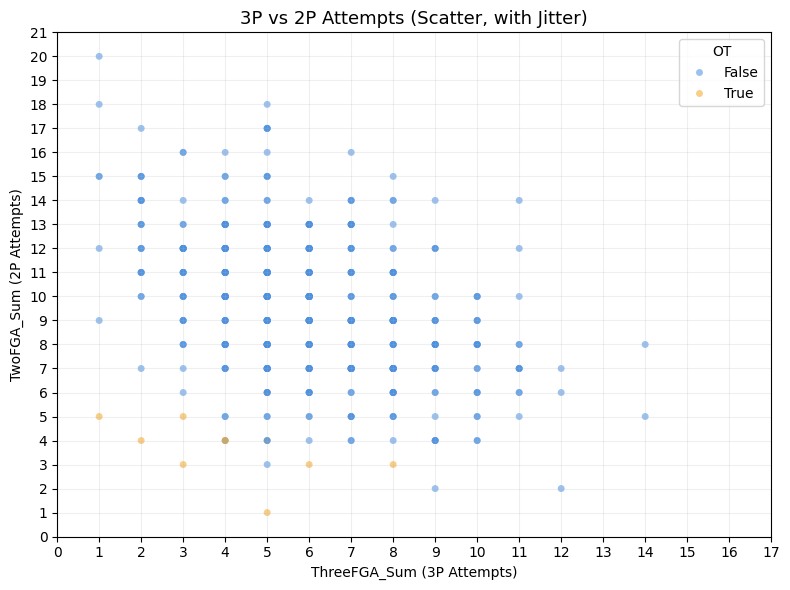

In [90]:
# ========== 越谷アルファーズ可視化：散布図 ==========
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data = action_counts_alphas,
    x="ThreeFGA_Sum",
    y="TwoFGA_Sum",
    hue="is_OT",
    palette={False: "#4A90E2", True: "#F5A623"},  # カラー固定で視認性UP
    s=25,         # 点をさらに小さく
    alpha=0.55,   # やや透過
    linewidth=0
)

plt.title("3P vs 2P Attempts (Scatter, with Jitter)", fontsize=13)
plt.xlabel("ThreeFGA_Sum (3P Attempts)")
plt.ylabel("TwoFGA_Sum (2P Attempts)")
plt.xticks(np.arange(0, 18, step=1))
plt.yticks(np.arange(0, 22, step=1))
plt.legend(title="OT")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

-0.173


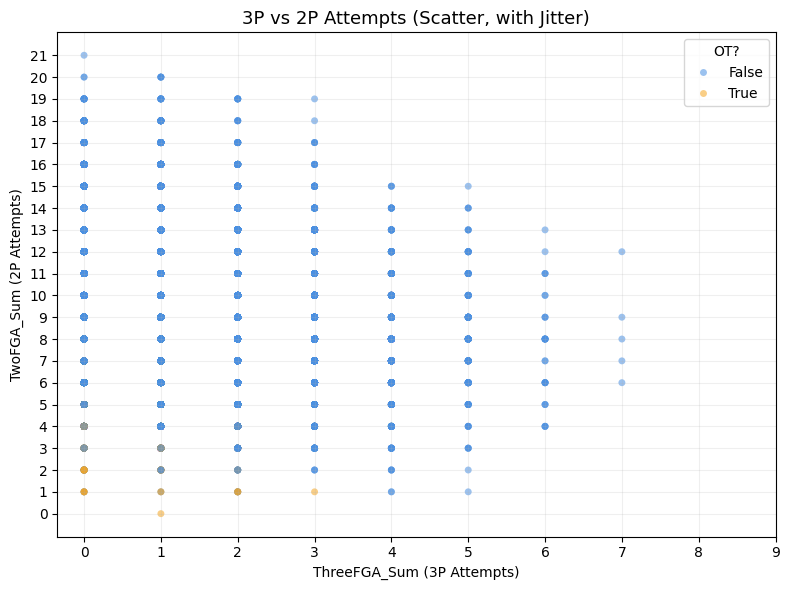

In [92]:
use_twopoint_outsidewing = summarize(pd.concat([use_twopoint, use_outsidewing], ignore_index=True))
overall_raw_twopoint_outsidewing = safe_corr(use_twopoint_outsidewing, "ThreeFGA_Sum","TwoFGA_Sum")
print(overall_raw_twopoint_outsidewing)


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=use_twopoint_outsidewing,
    x="ThreeFGA_Sum",
    y="TwoFGA_Sum",
    hue="is_OT",
    palette={False: "#4A90E2", True: "#F5A623"},  # カラー固定で視認性UP
    s=25,         # 点をさらに小さく
    alpha=0.55,   # やや透過
    linewidth=0
)

plt.title("3P vs 2P Attempts (Scatter, with Jitter)", fontsize=13)
plt.xlabel("ThreeFGA_Sum (3P Attempts)")
plt.ylabel("TwoFGA_Sum (2P Attempts)")
plt.xticks(np.arange(0, 10, step=1))
plt.yticks(np.arange(0, 22, step=1))
plt.legend(title="OT?")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()